{'1000': 2, '1001': 14, '0001': 139, '0000': 845}


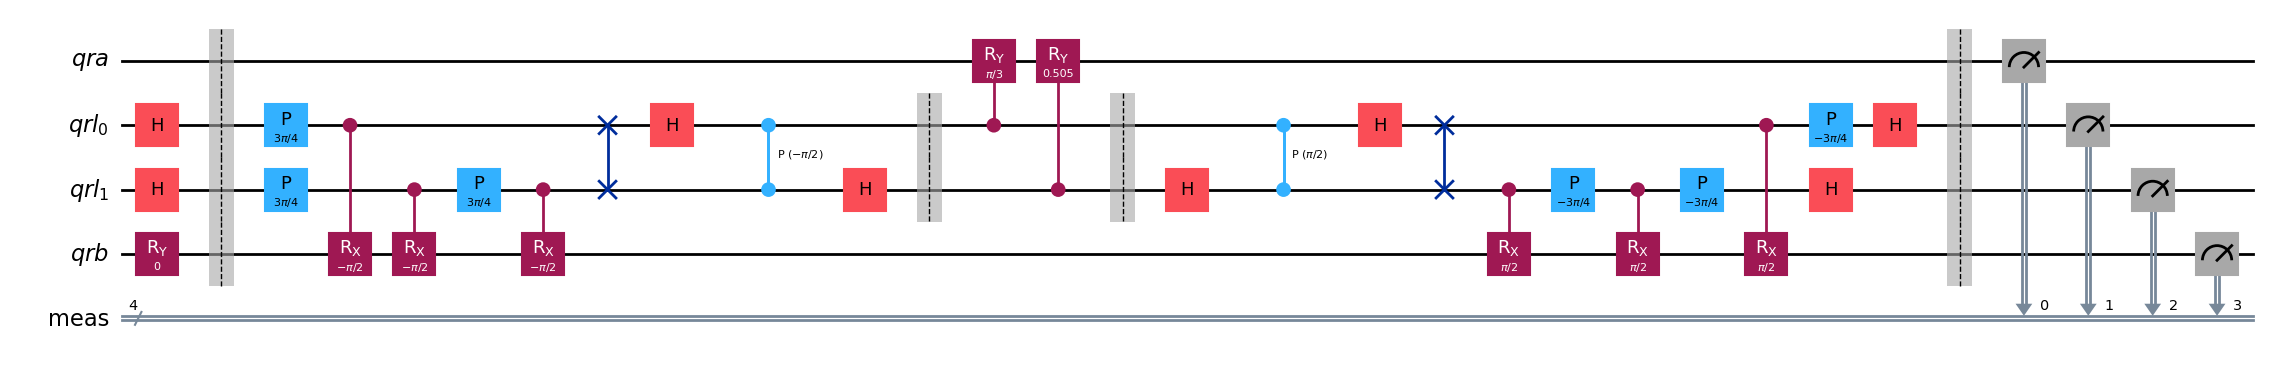

In [26]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import numpy as np

# ビット数、tの値
nb, nl, theta = 1, 2, 0
t = 2 * np.pi * 3 / 8

# 量子ビットの準備
qrb = QuantumRegister(nb, name='qrb')
qrl = QuantumRegister(nl, name='qrl')
qra = QuantumRegister(1, name='qra')

# 量子回路
qc = QuantumCircuit(qra, qrl, qrb)

# bの状態を作成
qc.ry(2 * theta, qrb[0])

# 量子位相推定
for qu in qrl:
    qc.h(qu)

qc.barrier()
qc.p(t, qrl[0])
qc.crx(-2 / 3 * t, qrl[0], qrb[0])
qc.p(t, qrl[1])
qc.crx(-2 / 3 * t, qrl[1], qrb[0])
qc.p(t, qrl[1])
qc.crx(-2 / 3 * t, qrl[1], qrb[0])

# 逆量子フーリエ変換
qc.swap(qrl[0], qrl[1])
qc.h(qrl[0])
qc.cp(-np.pi / 2, qrl[0], qrl[1])
qc.h(qrl[1])

# 固有値の逆数の回転
c = 1/3
t1 = 2 * np.arcsin(1 / 2)
t2 = 2 * np.arcsin(1 / 4)

qc.barrier(qrl)
qc.cry(t1, qrl[0], qra[0])
qc.cry(t2, qrl[1], qra[0])
qc.barrier(qrl)

# 量子フーリエ変換
qc.h(qrl[1])
qc.cp(np.pi / 2, qrl[0], qrl[1])
qc.h(qrl[0])
qc.swap(qrl[0], qrl[1])

qc.crx(2 / 3 * t, qrl[1], qrb[0])
qc.p(-t, qrl[1])
qc.crx(2 / 3 * t, qrl[1], qrb[0])
qc.p(-t, qrl[1])
qc.crx(2 / 3 * t, qrl[0], qrb[0])
qc.p(-t, qrl[0])

for qu in qrl:
    qc.h(qu)

# 測定
qc.measure_all()

# シミュレーションの設定
simulator = AerSimulator()

# トランスパイルと実行
compiled_circuit = transpile(qc, simulator)
result = simulator.run(compiled_circuit, shots=1000).result()

# 結果の取得と表示
counts = result.get_counts()
print(counts)
# plot_histogram(counts)
qc.draw(output='mpl', fold=100)


# 修正点の説明
# executeの置き換え: AerSimulatorを使用して、シミュレーションの実行を行っています。
# トランスパイルの追加: 量子回路をバックエンドに最適化するために、トランスパイル処理を追加しました。
# plot_histogramの保持: 結果を視覚化するために、ヒストグラムを表示しています。


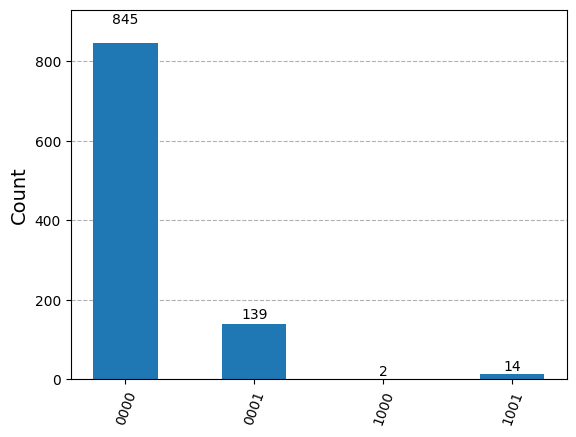

In [27]:
plot_histogram(counts)